In [117]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

from test_v8 import evaluate
from get_data import get_demos

demos = get_demos()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import torch
import transformers
from model_architectures import VisualPlanDiffuserV7
from get_data import get_demos

device = torch.device("cuda")
clip = transformers.CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch16")
model = VisualPlanDiffuserV7(clip).to(device) # type: ignore
model.load_state_dict(torch.load("diffusion_model.pt"))

demos = get_demos()


In [198]:
from score_visualization_3d import visualize_3d_score_function
from demo_to_state_action_pairs import create_labels_v3, prepare_image, CAMERAS
from test_v8 import sample, image_coordinates_to_noise_coordinates, image_scaling, center, scaled_arrows
import numpy as np
import matplotlib.pyplot as plt
import quaternions as Q

def evaluate(demo, output_prefix, starting_point, score_maps_to_visualize, chosen_cameras):
    state_action_tuples = create_labels_v3(demo)

    # Test with first keypoint.
    images, positions, quaternions, info = state_action_tuples[0]
    extrinsics = info['extrinsics']
    intrinsics = info['intrinsics']

    images = [prepare_image(image) for image in images]
    positions = torch.tensor(positions) * 224/128
    
    history, history_quats, history_2d, history_3d_per_view_scores, score_maps = sample(
        model,
        images,
        extrinsics,
        intrinsics,
        starting_point,
        chosen_cameras
    )
    
    grid_size = 14

    plt.clf()
    plt.figure(figsize=(6 * len(images), 6))

    # Plotting the score function in 2D.
    for i, (name, history_, position, image, score) in enumerate(zip(
        CAMERAS, zip(*history_2d), positions, images, score_maps
    )):
        position = torch.tensor(position, device=device)
        image = image.detach().cpu().numpy().transpose(1, 2, 0)

        scaled_target_position = image_coordinates_to_noise_coordinates(position, image_scaling, center)
        pixel_scaled_positions = torch.zeros((grid_size, grid_size, 2), device=device)
        pixel_scaled_positions[..., 0] = (0.5 + torch.arange(grid_size, device=device).view(grid_size, 1).expand(grid_size, grid_size)) * 2 / grid_size - 1
        pixel_scaled_positions[..., 1] = (0.5 + torch.arange(grid_size, device=device).view(1, grid_size).expand(grid_size, grid_size)) * 2 / grid_size - 1
        pixel_scaled_positions = pixel_scaled_positions.unsqueeze(0).expand(position.shape[0], -1, -1, -1)

        true_direction = (scaled_target_position.view(-1, 1, 1, 2) - pixel_scaled_positions)

        plt.subplot(1, len(images), i + 1)
        plt.title(name + " View")
        plt.imshow(image)
        plt.xlim(0, 224)
        plt.ylim(224, 0)
        # flip score function because of the flipped y axis
        score[..., 1] *= -1
        true_direction[..., 1] *= -1
        # plt.imshow(image.detach().cpu().numpy().permute(1, 2, 0), origin="lower")
        plt.scatter(
            [point[0].item() for point in history_],
            [point[1].item() for point in history_],
            label="Sampling trajectory",
            c=np.arange(len(history_)),
            cmap="viridis",
        )
        # Project from 2D memory layout to serial layout
        scaled_arrows(
            image,
            pixel_scaled_positions[0].view(-1, 2),
            score.view(-1, 2),
            true_direction[0].view(-1, 2),
        )
        # Visualize the quaternion
        show_quaternion = False
        if show_quaternion:
            for j in range(1, len(history_quats)):
                quat_as_matrix = extrinsics[i][:3, :3].T @ Q.quaternion_to_rotation_matrix(history_quats[j])
                
                arrow_scale = 10
                pos = history_[j - 1]

                # plot x, y, z axes of this matrix
                # only plot the label if it's the first one to avoid overcrowding the legend
                rotation_matrix_x, rotation_matrix_y, rotation_matrix_z = quat_as_matrix.T
                plt.quiver(pos[0], pos[1], rotation_matrix_x[0], rotation_matrix_x[1], scale=arrow_scale, color='r', label='x' if j == 1 else None, alpha=0.5)
                plt.quiver(pos[0], pos[1], rotation_matrix_y[0], rotation_matrix_y[1], scale=arrow_scale, color='g', label='y' if j == 1 else None, alpha=0.5)
                plt.quiver(pos[0], pos[1], rotation_matrix_z[0], rotation_matrix_z[1], scale=arrow_scale, color='b', label='z' if j == 1 else None, alpha=0.5)
        plt.legend()
        
    plt.tight_layout()
    plt.savefig(output_prefix + "_2d_multiview_sampling_trajectory.png", dpi=256)
    plt.clf()

    # Plot the history
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(projection='3d')
    buffer = 0.2
    ax.set_xlim(-0.3 - buffer, 0.7 + buffer)
    ax.set_ylim(-0.5 - buffer, 0.5 + buffer)
    ax.set_zlim(0.6 - buffer, 1.6 + buffer)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.plot(
        [point[0].item() for point in history],
        [point[1].item() for point in history],
        [point[2].item() for point in history],
        c='r'
    )
    # get depth data
    start_obs = info['start_obs']
    point_cloud_camera = CAMERAS[chosen_cameras[0]]
    point_cloud = getattr(start_obs, point_cloud_camera + '_point_cloud')
    points = point_cloud.reshape(-1, 3)
    colors = getattr(start_obs, point_cloud_camera + '_rgb')
    colors = colors.reshape(-1, 3) / 255.0
    ax.scatter(*points.T, c=colors, s=2, alpha=0.1)
    
    ax.set_box_aspect([1, 1, 1])

    true_pos = info['target_obs'].gripper_pose[:3]
    ax.scatter([true_pos[0]], [true_pos[1]], [true_pos[2]], color='r', label="True Position")
    start_pos = history[0].cpu().numpy()
    ax.scatter([start_pos[0]], [start_pos[1]], [start_pos[2]], color='g', label="Start Position")
    end_pos = history[-1].cpu().numpy()
    ax.scatter([end_pos[0]], [end_pos[1]], [end_pos[2]], color='b', label="End Position")
    
    print(start_pos, end_pos)
    
    # plot the extrinsics for each camera
    for i, extrinsic in enumerate(extrinsics):
        t = extrinsic[:3, 3]
        r = extrinsic[:3, :3].T
        scale = 0.5
        if i in chosen_cameras:
            for ax_, c in [(r[0], 'r'), (r[1], 'g'), (r[2], 'b')]:
                ax.plot([
                    t[0].item(), (t[0] + ax_[0] * scale).item()
                ], [
                    t[1].item(), (t[1] + ax_[1] * scale).item()
                ], [
                    t[2].item(), (t[2] + ax_[2] * scale).item()
                ], color=c)
                
                if c == 'b':
                    print("true z:", ax_)

        # plot the score direction
        # for j in range(len(history_3d_per_view_scores)):
        #     if i in [0, 1]:
        #         score_3d = history_3d_per_view_scores[j][i].detach().cpu().numpy() * 0.1
        #         # score_3d = history_3d_per_view_scores[j][i].detach().cpu().numpy()
        #         pt = history[j].cpu().numpy()
        #         ax.plot(
        #             [pt[0], pt[0] + score_3d[0]],
        #             [pt[1], pt[1] + score_3d[1]],
        #             [pt[2], pt[2] + score_3d[2]],
        #             color='black'
        #         )
    
    # plt.savefig(output_prefix + "_3d_sampling_trajectory.png")
    if len(score_maps_to_visualize) > 0:
        visualize_3d_score_function(
            [score_maps[i] for i in score_maps_to_visualize],
            [extrinsics[i] for i in score_maps_to_visualize],
            [intrinsics[i] for i in score_maps_to_visualize],
            ax=ax
        )
        
    plt.legend()
    plt.show()
    # plt.close()


/tmp/ipykernel_373459/2168959401.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  position = torch.tensor(position, device=device)


[0.1 0.6 1.4] [0.17944904 0.11203998 0.946295  ]
true z: [-9.06307936e-01  1.49011612e-07 -4.22617912e-01]
true z: [ 0.4161981  -0.07338715 -0.9063077 ]


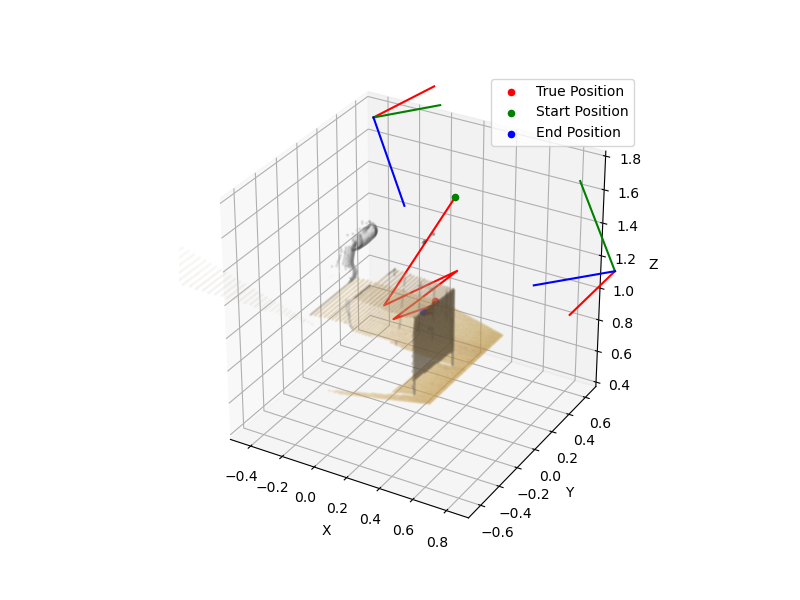

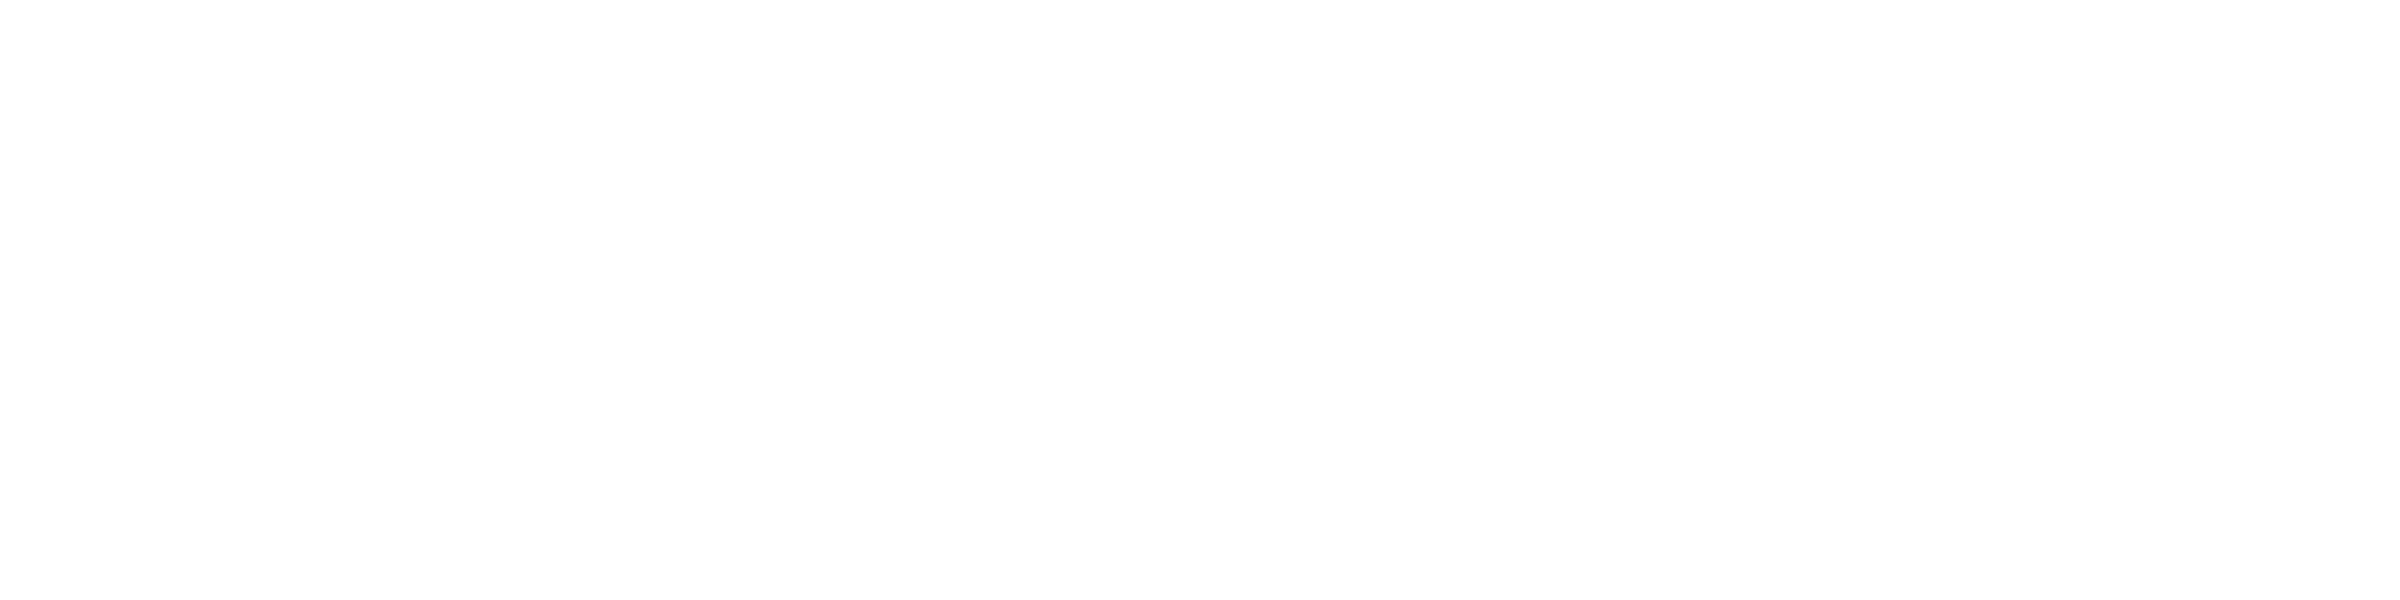

In [201]:
starting_point = torch.tensor([0.1, 0.6, 1.4], device=device)
# starting_point += torch.randn((3,), device=device) * 0.5

evaluate(demos[7], "demo_7", starting_point, score_maps_to_visualize=[], chosen_cameras=[0, 2])